In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
test = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)
batch_size=256

In [4]:
from cnn import CNN

In [5]:
trainloader = torch.utils.data.DataLoader(dataset=fashion, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=128, shuffle=False)

In [6]:
def load_subset(idx):
    f_path = f'subsets/split_{idx}'
    with open(f_path, 'rb') as f:
        subset = np.load(f)
    return subset

In [7]:
def load_model(idx):
    f_path = f'models/split_{idx}'
    model = CNN(10)
    model.load_state_dict(torch.load(f_path, weights_only=True))
    model.to(device)
    return model

In [11]:
def get_correctness_for_model(model):
    model.eval()
    trainset_correctness = []
    with torch.no_grad():
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            correctness = (predicted == targets).float()
            trainset_correctness.append(correctness)
    
    trainset_correctness = torch.cat(trainset_correctness).cpu()
    return trainset_correctness

In [ ]:
def get_correctness():
    results = []
    for idx in range(2000):
        if (idx+1) % 100 == 0:
            print(f'Loading results for idx {idx}...')
        subset_idx = load_subset(idx)
        mask = np.zeros(len(fashion), dtype=bool)
        mask[subset_idx] = True
        model = load_model(idx)
        correctness = get_correctness_for_model(model)
        results.append((mask, correctness))
    
    mask_matrix = np.vstack([ret[0] for ret in results])
    correctness_matrix = np.vstack([ret[1] for ret in results])

    return mask_matrix, correctness_matrix

In [13]:
trainset_mask, trainset_correctness = get_correctness()
with open('correctness.npy', 'wb') as f:
    np.save(f, trainset_correctness)
with open('trainset_mask.py', 'wb') as f:
    np.save(f, trainset_mask)

Loading results for idx 99...
Loading results for idx 199...
Loading results for idx 299...
Loading results for idx 399...
Loading results for idx 499...
Loading results for idx 599...
Loading results for idx 699...
Loading results for idx 799...
Loading results for idx 899...
Loading results for idx 999...
Loading results for idx 1099...
Loading results for idx 1199...
Loading results for idx 1299...
Loading results for idx 1399...
Loading results for idx 1499...
Loading results for idx 1599...
Loading results for idx 1699...
Loading results for idx 1799...
Loading results for idx 1899...
Loading results for idx 1999...


In [15]:
trainset_mask, trainset_correctness

(array([[ True, False,  True, ..., False, False,  True],
        [False,  True, False, ...,  True,  True, False],
        [False, False, False, ...,  True, False,  True],
        ...,
        [ True, False,  True, ...,  True,  True, False],
        [False, False,  True, ...,  True, False, False],
        [ True,  True, False, ..., False,  True,  True]],
       shape=(2000, 60000)),
 array([[0., 1., 1., ..., 1., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 1., 1., 0.],
        ...,
        [0., 0., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 0., 0., ..., 0., 0., 1.]], shape=(2000, 60000), dtype=float32))

In [16]:
inv_mask = np.logical_not(trainset_mask)

In [17]:
def masked_avg(x, mask, axis=0, esp=1e-10):
    return (np.sum(x * mask, axis=axis) / np.maximum(np.sum(mask, axis=axis), esp)).astype(np.float32)

In [18]:
mem_est = masked_avg(trainset_correctness, trainset_mask) - masked_avg(trainset_correctness, inv_mask)
mem_est

array([ 0.023     ,  0.02399999, -0.00300002, ...,  0.02399999,
        0.01800001,  0.00600001], shape=(60000,), dtype=float32)

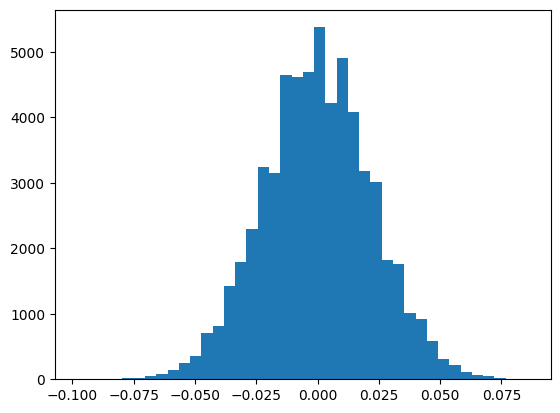

In [21]:
import matplotlib.pyplot as plt
plt.hist(mem_est, bins=40)
plt.show()

In [26]:
np.sum(trainset_mask, axis=0)

array([1000, 1000, 1000, ..., 1000, 1000, 1000], shape=(60000,))